# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

## Submission guidelines:

Your submission should only include this jupyter notebook named ex1_ID.ipynb.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in this jupyter notebook only.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only in your implementations. Any other imports are forbidden.
6. Your code must run without errors.
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What files do we need to upload to moodle?

A: jupyter notebook named ex1_313566747.ipynb

Q: Should you run your code and make sure everything works just before you submit? What will happen if your code cannot run?

A: Yes, if the code cannot run the tester will deduct points depending on the part that does not work.

Q: Should you add any other files in your submission?

A: No.

#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [2]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def download(base_url, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    filename = base_url.split("/")[-1]
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=base_url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")

def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

    plane       car       car     plane


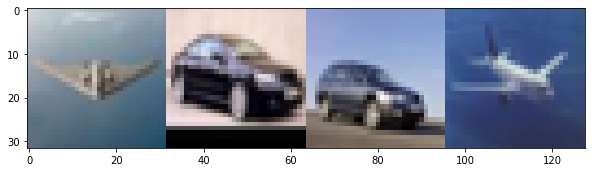

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
      rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
      rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
      grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))
    else:
      grid = np.hstack(np.array([np.asarray(i, dtype=np.int) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=False));

## Data Preprocessing Part 2

We have included several image processing functions. Notice the following in particular: We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [6]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [7]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***

        Inputs:
        - X: array of data
        - y: 1-dimensional array of length N with binary labels

        This function has no return value

        """
        num_features = X.shape[1]
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        self.W = 0.0001 * np.random.randn(num_features, num_classes)        

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label. 
        *** Subclasses will override this. ***

        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1). 
        """
        pass
        
    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances 
        that are classified correctly. 

        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """
        accuracy = 0.0
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        Y_prediction_train = self.predict(X)
        accuracy = np.count_nonzero((Y_prediction_train==y)) / y.shape[0]
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return accuracy


    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances, num_features = X.shape
        num_classes = np.max(y) + 1
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            X_batch = None
            y_batch = None

            ###########################################################################
            #                          START OF YOUR CODE                             #
            # TODO:                                                                   #
            # get a batch by randomly sampling the train set, calculate a loss and    #
            # gradient, and add the loss to the loss history                          #
            ###########################################################################
            sample_indices = np.random.choice(X.shape[0], batch_size)
            X_batch = X[sample_indices]
            y_batch = y[sample_indices]
            ###########################################################################
            #                           END OF YOUR CODE                              #
            ###########################################################################
            # perform parameter update
            loss, grad = self.loss(X_batch, y_batch)
            loss_history.append(loss)
            #########################################################################
            #                          START OF YOUR CODE                           #
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            self.W -= learning_rate * grad  
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history


    def loss(self, X, y):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(5 Points)**

In [8]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        #                          START OF YOUR CODE                             #
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################
        self.W = 0.0001 * np.random.randn(X.shape[1], 1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        predict = np.dot(X,self.W)
        y_pred = [1 if x > 0 else 0 for x in predict]
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [9]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

    plane     plane       car       car


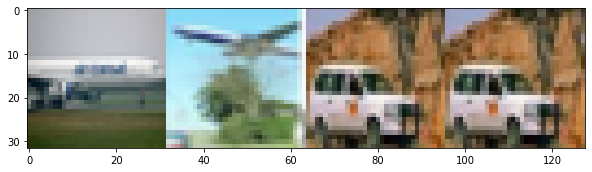

In [10]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch))
plt.show()

In [11]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

    plane       car       car     plane


## Evaluation 

Complete the class method `calc_accuracy`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(5 Points)**

In [12]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.6489


Your answer here: at the moment our model is not trained yet, so because of the random choice for the W weights vector in initially. we will get an accuracy percentage close to 50% since we have a total of 2 classes to choose from.

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [13]:
def perceptron_loss_naive(W, X, y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################
    t = np.expand_dims(np.copy(y), axis=1)
    t[np.where(y==0)] = -1
    for i in range(X.shape[0]):
        z = np.dot(W.T,X[i])
        res = t[i]*z
        loss += max(0,-res)
        if res < 0 :
            dW += -(np.expand_dims(X[i], axis=1) * t[i])
    loss /= X.shape[0]
    #############################################################################
    #                         END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [14]:
# weights are of the form FEATURES X CLASS (in the binary case CLASS=1)
W = np.random.randn(3073, 1) * 0.0001

In [15]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.121326
Wall time: 25.4 ms


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. **(15 points)**

In [16]:
def perceptron_loss_vectorized(W, X, y):
    """
    Vectorized version of perceptron_loss_naive. instead of loops, should use 
    numpy vectorization.

    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the perceptron loss, storing the       #
    # result in loss and the gradient in dW                                     #
    #############################################################################
    t = np.expand_dims(np.copy(y), axis=1)
    t[np.where(y==0)] = -1
    z = np.dot(X, W)
    res = z * t
    # we set the value to max(0,-res)
    cost = np.where(res < 0, -res, 0)
    indicator = np.where(cost != 0, 1, 0)
    loss = np.mean(cost)
    # setting the gradiant to the right direction
    dW = -(np.dot(X.T, (indicator * t))) / X.shape[0]
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [17]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

loss: 0.121326
difference: 320595.621542
Wall time: 6.99 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class. (**10 points**)

In [18]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 0.127462
iteration 100 / 1500: loss 0.030063
iteration 200 / 1500: loss 0.014846
iteration 300 / 1500: loss 0.013099
iteration 400 / 1500: loss 0.021793
iteration 500 / 1500: loss 0.020778
iteration 600 / 1500: loss 0.017517
iteration 700 / 1500: loss 0.011265
iteration 800 / 1500: loss 0.015355
iteration 900 / 1500: loss 0.010956
iteration 1000 / 1500: loss 0.012744
iteration 1100 / 1500: loss 0.013193
iteration 1200 / 1500: loss 0.016045
iteration 1300 / 1500: loss 0.011653
iteration 1400 / 1500: loss 0.008421
Wall time: 2.64 s


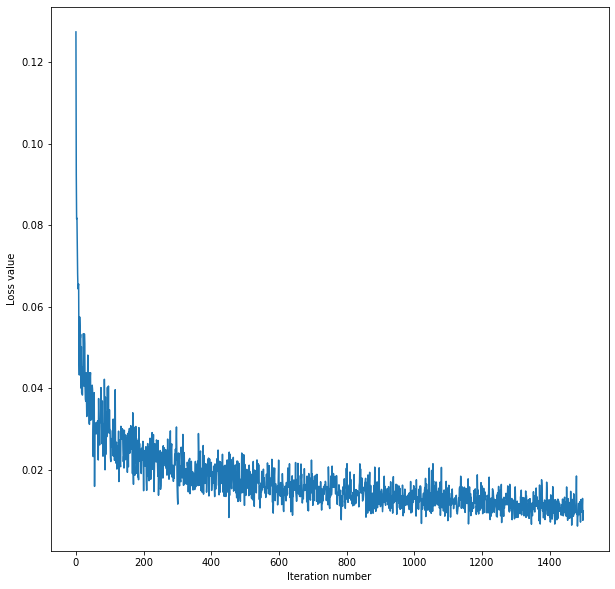

In [19]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.7736
Testing accuracy:  0.768


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [21]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
# Checking the diffrent learning rates. 
for i in learning_rates:
    # Checking all of the diffrent batch saze. 
    for batch_size in batch_sizes:
        iterations = batch_size*3
        perceptron = LinearPerceptron(X_train, y_train)
        perceptron.train(X_train, y_train, learning_rate=i,
                         batch_size=batch_size, num_iters=iterations)
        train_accuracy = perceptron.calc_accuracy(X_train, y_train)
        val_accuracy = perceptron.calc_accuracy(X_val, y_val)
        results[(i, batch_size)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_perceptron = perceptron

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.402000 val accuracy: 0.382000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.752200 val accuracy: 0.764000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.770000 val accuracy: 0.756000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.777800 val accuracy: 0.762000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.425900 val accuracy: 0.400000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.794600 val accuracy: 0.784000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.821100 val accuracy: 0.821000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.658200 val accuracy: 0.645000
best validation accuracy achieved during cross-validation: 0.821000
linear perceptron on raw pixels final test set accuracy: 0.816000


## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier.

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. **(10 Points)**

In [22]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.

    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement the function                                                    #
    #############################################################################
    return 1/(1+np.exp(-x))
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [23]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################
        self.W = 0.0001 * np.random.randn(X.shape[1], 1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        pred = sigmoid(np.dot(X,self.W))
        y_pred = [1 if x > 0.5 else 0 for x in pred]
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [24]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

    plane       car       car     plane


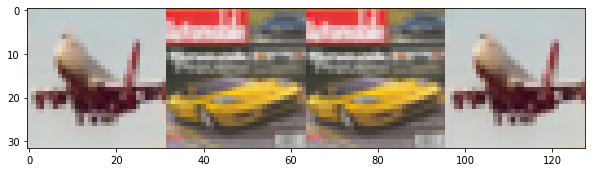

In [25]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [26]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane         plane           car         plane


In [27]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.639


## Binary cross-entropy

Your code for this section will written in the next cell. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W. (**20 points**)

In [28]:
def binary_cross_entropy(W, X, y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1). 
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################
    
    t = np.expand_dims(y, axis=1)
    pred = np.dot(X, W)
    loss = np.mean(-np.log(sigmoid(t*pred)+1e-15))
    dW = np.dot(X.T, (-sigmoid(-t * pred) * t)) / X.shape[0]

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [29]:
W = np.random.randn(3073, 1) * 0.0001

In [30]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.685878
Wall time: 3.07 ms


You are provided with a gradient test in the next cells:

In [31]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [32]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 4.019959 analytic: 4.019959, relative error: 1.479947e-09
numerical: 3.715802 analytic: 3.715802, relative error: 1.064108e-08
numerical: 2.606675 analytic: 2.606675, relative error: 9.968900e-09
numerical: 2.927253 analytic: 2.927253, relative error: 1.898472e-09
numerical: 1.979883 analytic: 1.979883, relative error: 1.019609e-09
numerical: -1.816785 analytic: -1.816785, relative error: 5.777188e-09
numerical: 5.887947 analytic: 5.887947, relative error: 1.359290e-09
numerical: 3.166946 analytic: 3.166946, relative error: 3.747537e-09
numerical: 3.481199 analytic: 3.481199, relative error: 4.277444e-09
numerical: 5.825567 analytic: 5.825567, relative error: 2.351775e-09


If implemented correctly, the training procedure you already implemented should work.

In [33]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 0.681356
iteration 100 / 1500: loss 0.588204
iteration 200 / 1500: loss 0.590042
iteration 300 / 1500: loss 0.561450
iteration 400 / 1500: loss 0.561618
iteration 500 / 1500: loss 0.580132
iteration 600 / 1500: loss 0.520609
iteration 700 / 1500: loss 0.566643
iteration 800 / 1500: loss 0.533497
iteration 900 / 1500: loss 0.534608
iteration 1000 / 1500: loss 0.554119
iteration 1100 / 1500: loss 0.570666
iteration 1200 / 1500: loss 0.526125
iteration 1300 / 1500: loss 0.503373
iteration 1400 / 1500: loss 0.582434
Wall time: 2.58 s


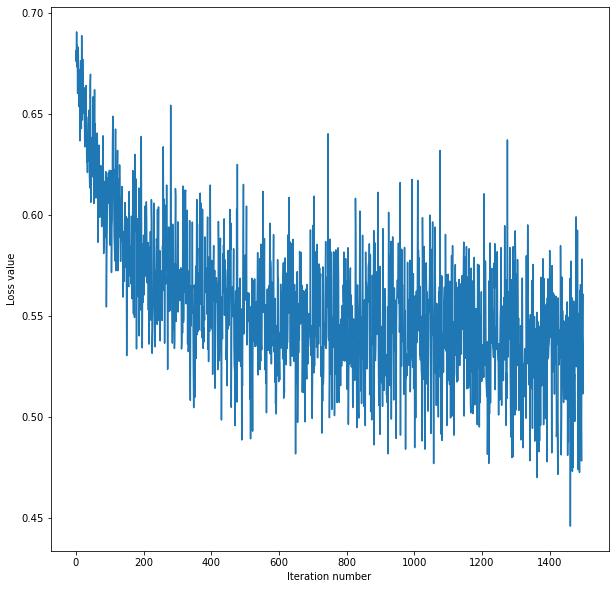

In [34]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [35]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  0.7868
Testing accuracy:  0.819


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [38]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
# Checking all of the diffrent learning rates. 
for i in learning_rates:
    # Checking all of the diffrent batch saze. 
    for batch_size in batch_sizes:
        iterations = batch_size*3
        Logistic = LogisticRegression(X_train, y_train)
        Logistic.train(X_train, y_train, learning_rate=i,
                         batch_size=batch_size, num_iters=iterations)
        train_accuracy = Logistic.calc_accuracy(X_train, y_train)
        val_accuracy = Logistic.calc_accuracy(X_val, y_val)
        results[(i, batch_size)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_logistic = Logistic

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 batch_size 1.000000e+00 train accuracy: 0.536800 val accuracy: 0.524000
lr 1.000000e-07 batch_size 1.000000e+02 train accuracy: 0.768200 val accuracy: 0.780000
lr 1.000000e-07 batch_size 2.000000e+02 train accuracy: 0.778700 val accuracy: 0.791000
lr 1.000000e-07 batch_size 5.000000e+02 train accuracy: 0.784100 val accuracy: 0.796000
lr 5.000000e-06 batch_size 1.000000e+00 train accuracy: 0.470100 val accuracy: 0.437000
lr 5.000000e-06 batch_size 1.000000e+02 train accuracy: 0.796900 val accuracy: 0.794000
lr 5.000000e-06 batch_size 2.000000e+02 train accuracy: 0.804500 val accuracy: 0.809000
lr 5.000000e-06 batch_size 5.000000e+02 train accuracy: 0.809400 val accuracy: 0.816000
best validation accuracy achieved during cross-validation: 0.816000
Binary logistic regression on raw pixels final test set accuracy: 0.830000


## Weight Visualization

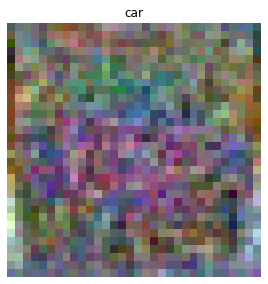

In [39]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

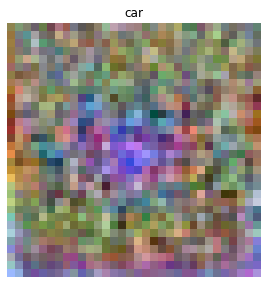

In [40]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

####**Question:** Explain the possible reasons for the differences in the visualization of the weights in the both cases, also are the car weights for the perceptron and logistic models similiar? what can you say about that? **(5 points)**

There is a several reasons for the differnces in the visualization of the weights. one of them is our random W that we train each model in a saprate model. another one is that the logistic regression uses a logistic function and the perceptron uses a step function. 

# The End!